Импорт необходимых библиотек

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
from torch.utils.data import Dataset, DataLoader
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [4]:
# выбираем на чем будем обучаться
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

Чтение данных и предобработка. Модель будет включать в себя информацию из этих двух таблиц, но возможно улучшение при достаточных вычислительных мощностях. Например, можно создать дополнительные эмбединги жанров из таблицы Movies, тэгов, которые пользователи поставили фильмам и релевантности тэгов из genome_scores

In [5]:
movies = pd.read_csv('./ml-latest/movies.csv')
ratings = pd.read_csv('./ml-latest/ratings.csv')

Преобразуем id фильмов в формат, удобный для работы с эмбедингами, чтобы при вычислении индекс не выходил для границы размера эмбединга

In [6]:
movie_to_idx = {}  # словарь для хранения нового индекса вместе со старым
for idx, movie_id in enumerate(movies['movieId']):
    movie_to_idx[movie_id] = idx
# задаем новую колонку в таблице ratings с новыми id фильмов
ratings['movieIdx'] = ratings['movieId'].apply(lambda x: movie_to_idx[x])

In [7]:
train_data, val_data = train_test_split(
    ratings, test_size=0.2, random_state=42)  # разбиваем данные на трейн/тест в соотношении 80:20

Определение класса датасета для наших данных. Так как объем данных на обучение большой, целесообразно будет обучаться через батчи. Для этого нужно определить датасет и закинуть его в даталоадер

In [8]:
class RatingsDataset(Dataset):
    def __init__(self, ratings):  # инициализируем таблицей ratings
        # переводим все данные в тензоры
        self.user_ids = torch.LongTensor(ratings['userId'].values)
        self.movie_ids = torch.LongTensor(ratings['movieIdx'].values)
        self.ratings = torch.FloatTensor(ratings['rating'].values)

    def __len__(self):
        return len(self.user_ids)

    def __getitem__(self, idx):
        return self.user_ids[idx], self.movie_ids[idx], self.ratings[idx]

Для решения поставленной задачи был выбран подход матричной факторизации. Условно архитектура нейронной сети делится на 2 части. Первая часть отвечает за создание эмбедингов пользователя и фильма, а вторая за их объединение и вычисление рейтинга путём 3 линейных слоёв. Также для контроля над переобучением было добавлено 3 слоя dropout, которые отсеивают некоторые нейроны с вероятностью 0.2. Функция активации стандартная для линейных слоёв - ReLu.

In [9]:
class Recommender(nn.Module):
    # передаем кол-во пользователей, кол-во фильмов, размерность эмбединга
    def __init__(self, num_users, num_movies, emb_size=50):
        super().__init__()
        # определяем слой эмбединга пользователей используя число уникальных пользователй и заданую размерность
        self.user_emb = nn.Embedding(num_users, emb_size)
        # делаем тоже самое что и с эмбедингом пользователя, но уже с числом уникальных фильмов
        self.movie_emb = nn.Embedding(num_movies, emb_size)
        # линейный слой 1. Так как мы объединили два эмбединга, то вход у этого слоя равен двойной размерности эмбедингов
        self.fc1 = nn.Linear(2 * emb_size, 100)
        # линейный слой 2. Постепенно снижаем размерность
        self.fc2 = nn.Linear(100, 50)
        # линейный слой 3. Получаем значения рейтинга для i-ого пользователя для j-ого фильма
        self.fc3 = nn.Linear(50, 1)
        # слой dropout для контроля над переобучением
        self.dropout = nn.Dropout(p=0.2)

    # forward основная функция которая отображает последовательность действий нашей сети
    def forward(self, user_ids, movie_ids,):
        # сначала получаем эмбединги пользователей
        user_emb = self.user_emb(user_ids)
        movie_emb = self.movie_emb(movie_ids)  # затем фильмов
        # объединяем их используя конкатенацию
        x = torch.cat([user_emb, movie_emb], dim=1)
        x = self.dropout(x)  # пропускаем через dropout
        # пропускаем через линейный слой и функцию активации после него
        x = nn.functional.relu(self.fc1(x))
        x = self.dropout(x)  # пропускаем через dropout
        # пропускаем через следующий линейный слой и функцию активации после него
        x = nn.functional.relu(self.fc2(x))
        x = self.dropout(x)  # пропускаем через dropout
        x = self.fc3(x)  # финальный слой
        return x.squeeze()  # выполняем операцию squeeze чтобы перейти к одномерной размерности, в которой находятся true значения рейтинга

Инициализация сети, функции потерь и оптимизатора. Инициализируем количеством уникальных пользователей и фильмов. Добавляем 1, чтобы в процесс обучения не выйти за границу эмюединга
Так как вторая часть архитектуры сети выполняет задачу регрессии, то функция потерь будет MSE (Mean Squared Error), вычисляющая квадратичное отклонение предсказанного рейтинга от реального значения

Оптимизатор Adam был выбран, так как он хорошо показывает себя при работе с большими объемами данных. Также один из основных плюсов данного оптимизатора это адаптивная скорость обучения для каждого параметра, что при апгрейде модели и добавления эмбедингов других фичей будет плюсом.

In [10]:
model = Recommender(num_users=ratings['userId'].nunique()+1,
                    num_movies=movies['movieId'].nunique()+1,
                    emb_size=50).to(device)
criterion = nn.MSELoss()
# передаем в оптимизатор параметры модели
optimizer = optim.Adam(model.parameters(), lr=0.001)

Определяем классический цикл обучения модели состящий из прохода по батчам в даталоадере, вычисления таргета,
вычисления лосс функции между таргетом и реальным значением, выполнением алгоритма обратного прохода по лосс функции и корректировкой оптимизатором параметров модели


In [11]:
def train(model, dataloader, criterion, optimizer):
    model.train()  # перевод в режим обучения
    # переменная для хранения лосс значения батча
    running_loss = 0.0
    for user_ids, movie_ids, ratings in dataloader:
        optimizer.zero_grad()  # обнуляем градиенты
        # отправляем тензоры данных на платформу, на которой обучаемся CPU или CUDA, получаем предикт
        preds = model(user_ids.to(device), movie_ids.to(device))
        # вычисляем значение лосс функции
        loss = criterion(preds, ratings)
        loss.backward()  # выполняем обратный проход
        optimizer.step()  # корректируем параметры модели
        # добавляем очередное значение лосс функции
        running_loss += loss.item()
    # вычисляем среднее значение лосс функции для этого вызова фукнции
    return running_loss / len(dataloader)

In [12]:
def evaluate(model, dataloader, criterion):
    model.eval()  # перевод в режим тестирования
    running_loss = 0.0  # тоже самое, что и для обучения
    with torch.no_grad():  # блокируем градиенты и смотрим как модель ведет себя на новых данных
        for user_ids, movie_ids, ratings in dataloader:  # проход по элементам батча
            # вычисляем очередное значение предикта
            preds = model(user_ids.to(device), movie_ids.to(device))
            # вычисляем значение лосс функции
            loss = criterion(preds, ratings)
            running_loss += loss.item()
    # возвращаем среднее значение лосс функции для этого вызова
    return running_loss / len(dataloader)

После определения функций для обучения и валидации запускается цикл на заданное количество эпох, в каждой эпохе вызываются функции обучения и валидации. На каждой итерации средние значения для конкретной эпохи записываются в список

In [ ]:
# датасет для обучения
train_dataset = RatingsDataset(train_data)
# даталоадер для обучения
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
# датасет для валидации
val_dataset = RatingsDataset(val_data)
# даталоадер для валидации
val_loader = DataLoader(val_dataset, batch_size=256, shuffle=False)
# хранение лосс значений для обучения и валидации
train_loss_hist = []
val_loss_hist = []
num_epochs = 20
for epoch in range(num_epochs):
    train_loss = train(model, train_loader, criterion, optimizer)
    train_loss_hist.append(train_loss)
    val_loss = evaluate(model, val_loader, criterion)
    val_loss_hist.append(val_loss)
    print(
        f'Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

In [13]:
from sklearn.metrics import r2_score


def evaluate_metrics(model, dataloader):
    r2_hist = []
    model.eval()  # перевод в режим тестирования
    with torch.no_grad():  # блокируем градиенты и смотрим как модель ведет себя на новых данных
        for user_ids, movie_ids, ratings in dataloader:  # проход по элементам батча
            # вычисляем очередное значение предикта
            preds = model(user_ids.to(device), movie_ids.to(device))
            # вычисляем значение r^2
            loss = r2_score(ratings, preds)
            r2_hist.append(loss.item())
    return r2_hist  # возвращаем среднее значение r^2

Сохраняем результаты обучения

In [ ]:
np.save("train_loss.npy", train_loss_hist)
np.save("test_loss.npy", val_loss_hist)

Сохраняем модель

In [ ]:
torch.save(model, "./model.pt")

Загружаем модель

In [14]:
model = torch.load("./model.pt", map_location=torch.device('cpu'))

Вычисляем R^2

In [94]:
r2 = evaluate_metrics(model, val_loader)
np.save("r2_score.npy", r2)

Изображем распредление значений R^2

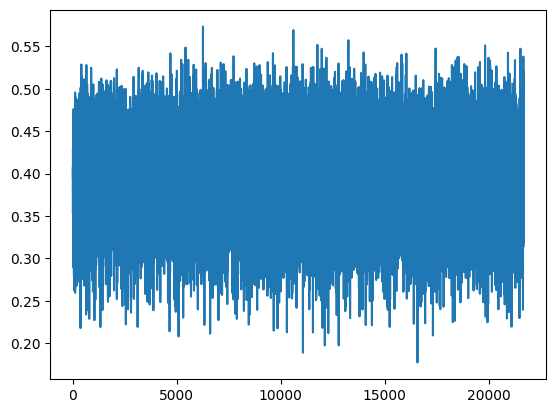

In [93]:
plt.plot(r2)

Значение R^2 равное 0,39 означает что построенная модель и выбранные признаки объясняют 40% дисперсии данных. 60% приходится на другие факторы. Например жанры фильмов, тэги пользователей или год выпуска фильма и так далее.

In [96]:
np.mean(r2)

0.3949117717131548

In [75]:
train_loss = np.load("./train_loss.npy")
val_loss = np.load("./test_loss.npy")

Изображение графиков значений лосс функции для тестирования и валидации
Как видно из графиков модель не имеет сильного переобучения. Граница переобучения находится примерно на 18,19 эпохе.
Тем не менее график лосс функции для валидации имеет удовлетворительное снижение значения лосс функции

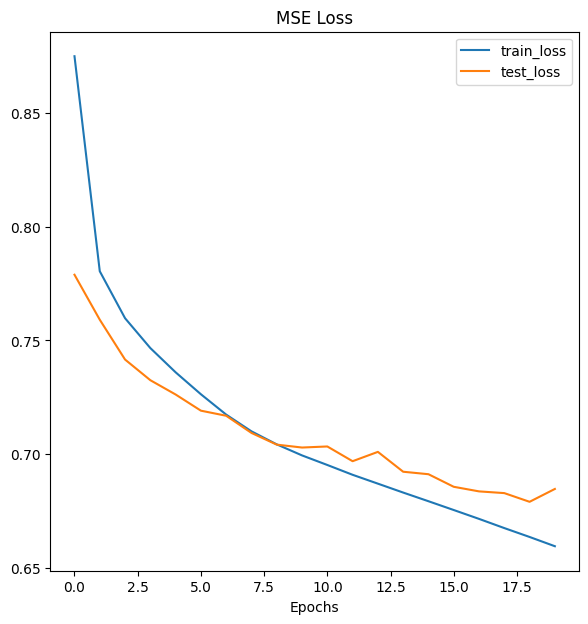

In [92]:
plt.figure(figsize=(15, 7))
plt.subplot(1, 2, 1)
plt.plot(range(len(train_loss)), train_loss, label="train_loss")
plt.plot(range(len(val_loss)), val_loss, label="test_loss")
plt.title("MSE Loss")
plt.xlabel("Epochs")
plt.legend()

N рекомендуемых фильмов выбираются путем сортировки прогнозируемых рейтингов в порядке убывания и выбора n лучших. Это делается путем первого применения маски к прогнозируемым рейтингам с использованием логической индексации, затем с помощью метода argsort() для получения индексов, которые отсортировали бы массив в порядке возрастания, и, наконец, отрицания результата и получения первых n индексов с помощью [:n]. Результирующие индексы соответствуют n лучшим фильмам, которые пользователь еще не оценил.

In [15]:
def get_top_n_recommendations(user_id, model, movies_df, ratings_df, n):
    all_movies = torch.LongTensor(movies_df['movieId'].values) #получаем тензор всех фильмов

    user_ratings = ratings_df[ratings_df['userId'] == user_id] #получаем срез датасета, где фигурирует заданный пользователь
    user_movies = torch.LongTensor(user_ratings['movieId'].values) #получаем Id фильмов, которые он оценил

    mask = torch.ones_like(all_movies, dtype=torch.bool) #создаем маску что поменить фильмы, которые он уже видел
    mask[user_movies] = False #помечаем эти фильмы флагом False

    user_ids = torch.LongTensor([user_id] * len(all_movies)) # тензор user_ids создается с размером тензора всех фильмов, чтобы соблюсти размеры эмбедингов
    predicted_ratings = model(user_ids, all_movies).detach().numpy() # вычисляются рейтиги и значения убираются из вычислительного графа и переводятся в массив numpy

    top_n_indices = (-predicted_ratings[mask]).argsort()[:n] #сортируем рейтинги учитывая значения маски и получаем значения индексов для рекомендации
    top_n_movies = all_movies[mask][top_n_indices].numpy() #выводим информацию об этих фильмах, используя полученные индексы

    return movies_df[movies_df['movieId'].isin(top_n_movies)]

Результаты выполнения функции и получение

In [26]:
user_id = 432
num_recommendations = 10
top_n_movies = get_top_n_recommendations(
    user_id, model, movies, ratings, num_recommendations)
print(top_n_movies)

       movieId                                   title                  genres
312        315                  Specialist, The (1994)   Action|Drama|Thriller
828        843                       Lotto Land (1995)                   Drama
870        887                   Talk of Angels (1998)                   Drama
878        895                    Venice/Venice (1992)                   Drama
1102      1125  Return of the Pink Panther, The (1975)            Comedy|Crime
1158      1181                     Shooter, The (1997)                 Western
10026    32943                    Life Is Sweet (1990)            Comedy|Drama
10330    34540                Pretty Persuasion (2005)            Comedy|Drama
11316    47937                        Severance (2006)  Comedy|Horror|Thriller
11735    51678                    Julius Caesar (1953)                   Drama
